In [1]:
!pip install split_folders

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import random
import splitfolders
import os

In [2]:
os.makedirs('output1')
os.makedirs('output1/train')
os.makedirs('output1/val')
os.makedirs('output1/test')

path = "skin diseases1"

splitfolders.ratio(path,output ="output1",ratio = (0.80,.1,.1))

Copying files: 4500 files [01:06, 67.92 files/s]


In [3]:
def random_image(val_dir,val_class):
    folder = val_dir +val_class
    random_image = random.sample(os.listdir(folder),1)
    img = mping.imread(folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(val_class)
    return img

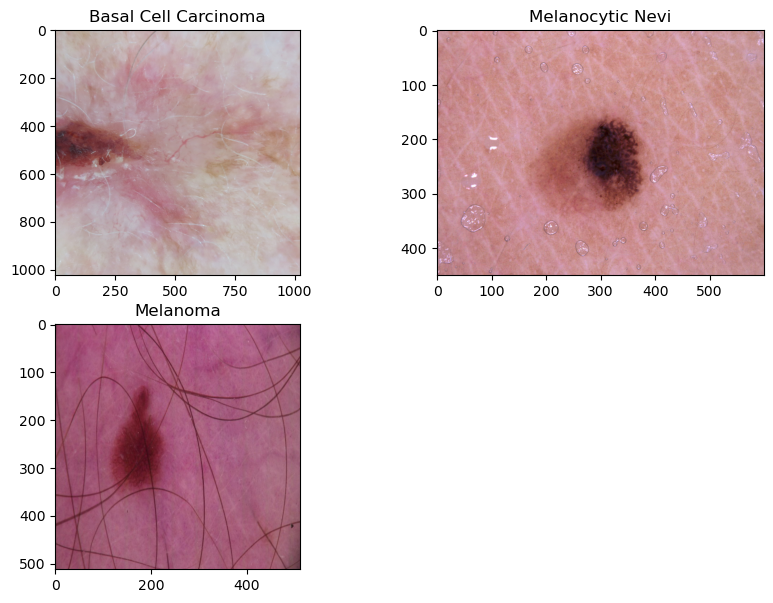

In [4]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2,2,1)
img_1 = random_image(val_dir = "output1/val/",val_class = "Basal Cell Carcinoma")
fig.add_subplot(2,2,2)
img_2 = random_image(val_dir = "output1/val/",val_class = "Melanocytic Nevi")
fig.add_subplot(2,2,3)
img_3 = random_image(val_dir = "output1/val/",val_class = "Melanoma")

In [5]:
import tensorflow as tf
from tensorflow.keras import layers


In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "output1/train"
test_dir =  "output1/test"
val_dir = "output1/val"

train_data = image_dataset_from_directory(train_dir,label_mode = "categorical",
                                          image_size = (224,224),batch_size = 32,
                                         shuffle = True,seed = 42)
test_data = image_dataset_from_directory(test_dir,label_mode = "categorical",
                                          image_size = (224,224),batch_size = 32,
                                         shuffle = False,seed = 42)
val_data = image_dataset_from_directory(val_dir,label_mode = "categorical",
                                          image_size = (224,224),batch_size = 32,
                                         shuffle = False,seed = 42)

Found 3600 files belonging to 3 classes.
Found 450 files belonging to 3 classes.
Found 450 files belonging to 3 classes.


In [7]:
from tensorflow.keras.layers.experimental import preprocessing

data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal")
],name = "data_augmentation_layer")

In [8]:
model = tf.keras.applications.EfficientNetB7(include_top = False)
model.trainable = False

In [9]:
inputs = layers.Input(shape = (224,224,3),name = "input_layer")
x = data_aug(inputs)
x = model(x)
x = layers.GlobalAvgPool2D(name = "pooling_layer")(x)
# parameter used to specify the size of the output generated from the layer.
x = layers.Dense(32,activation = "relu",kernel_initializer = tf.keras.initializers.he_normal())(x)
x = layers.Dense(3)(x)
outputs = layers.Activation("softmax",dtype = tf.float32)(x)
model = tf.keras.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, None, None, 3)    0         
 quential)                                                       
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 pooling_layer (GlobalAverag  (None, 2560)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 32)                81952     
                                                                 
 dense_1 (Dense)             (None, 3)                 99    

In [10]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [11]:
ES = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

RL = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)


In [12]:
history= model.fit(train_data,epochs =20 , validation_data = val_data, 
                      callbacks = [ES,RL])

Epoch 1/20
113/113 [==============================] - 953s 8s/step - loss: 0.4970 - accuracy: 0.8044 - val_loss: 0.3748 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 2/20
113/113 [==============================] - 935s 8s/step - loss: 0.3889 - accuracy: 0.8444 - val_loss: 0.3111 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 3/20
113/113 [==============================] - 928s 8s/step - loss: 0.3537 - accuracy: 0.8628 - val_loss: 0.3177 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 4/20
113/113 [==============================] - 980s 9s/step - loss: 0.3286 - accuracy: 0.8692 - val_loss: 0.3628 - val_accuracy: 0.8578 - lr: 0.0010
Epoch 5/20
113/113 [==============================] - 1036s 9s/step - loss: 0.3181 - accuracy: 0.8703 - val_loss: 0.3231 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 6/20
113/113 [==============================] - 1021s 9s/step - loss: 0.3101 - accuracy: 0.8764 - val_loss: 0.2902 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 7/20
113/113 [==============================] - 994s 9s/

In [13]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

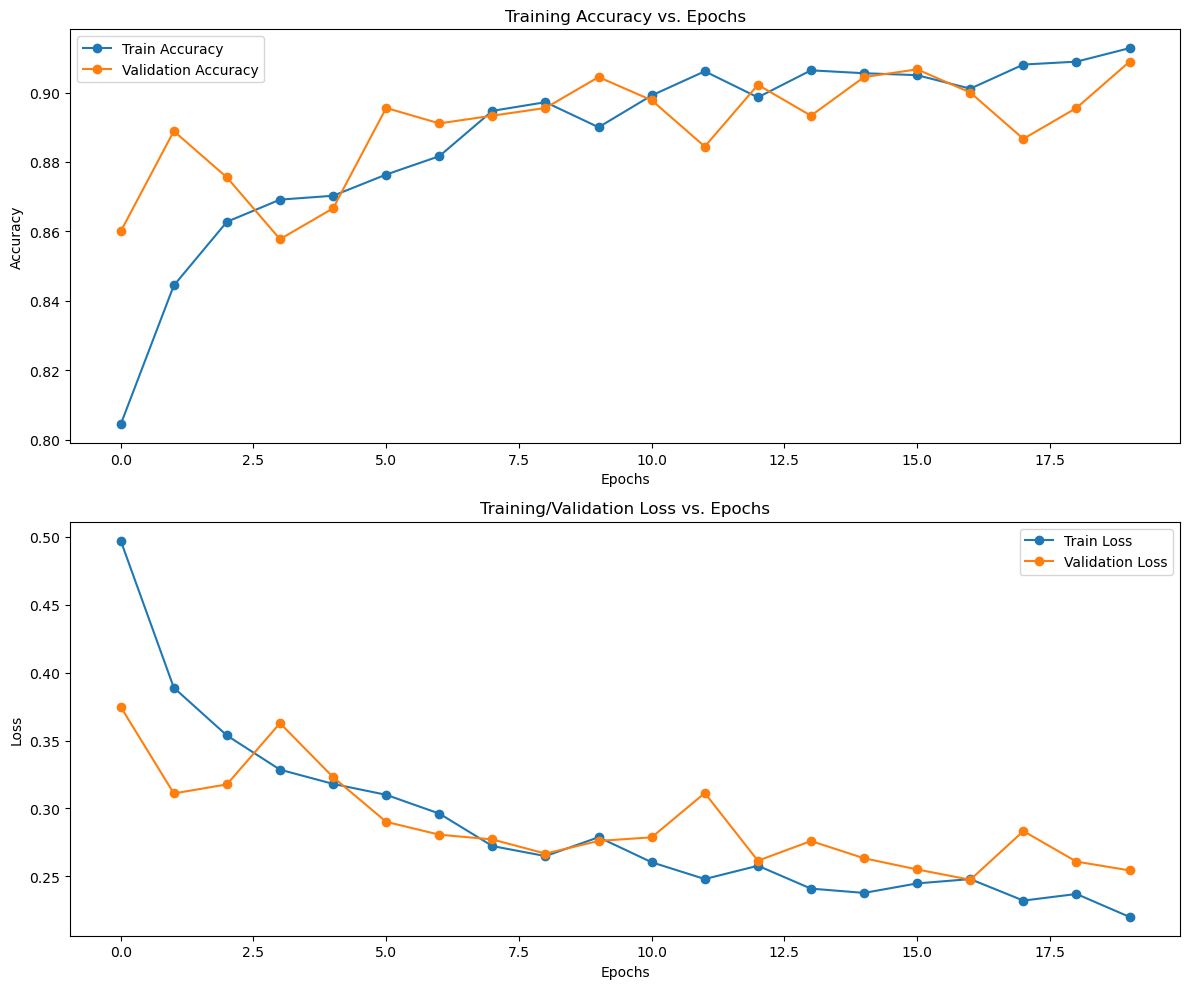

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,10))


ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')


ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.savefig('sevenlayercnn_epoch_graph2.jpg',dpi=300)
plt.show()


In [15]:
print("Testing Accuracy",model.evaluate(test_data)) 

15/15 [==============================] - 120s 8s/step - loss: 0.2511 - accuracy: 0.8911
Testing Accuracy [0.25114160776138306, 0.8911111354827881]


In [16]:
model.save_weights("skin_model2.hdf5")

In [17]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
model.load_weights("skin_model2.hdf5")

In [18]:
test_dir =  "output1/test"
test_datagen=ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224,224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

Found 450 images belonging to 3 classes.


In [19]:
y_pred=model.predict(test_generator)
pred=np.argmax(y_pred,axis=1)

450/450 [==============================] - 154s 332ms/step


In [20]:
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
confusion_matrix(test_generator.classes,pred)

array([[146,   2,   2],
       [ 10, 123,  17],
       [  3,  14, 133]], dtype=int64)

In [22]:
print(classification_report(test_generator.classes,pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       150
           1       0.88      0.82      0.85       150
           2       0.88      0.89      0.88       150

    accuracy                           0.89       450
   macro avg       0.89      0.89      0.89       450
weighted avg       0.89      0.89      0.89       450

